# Setup Notebook and GPU

In [ ]:
# Monunt google drive to import KEGG dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting Colab's GPU
# Edit > Notebook Settings > GPU 
!nvidia-smi -L
# Detailed GPU Information Reference: https://medium.com/analytics-vidhya/the-google-colab-system-specification-check-69d159597417
# !nvidia-smi -q

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-23e113bc-0d4e-4014-9456-56112fa82a03)


In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.178
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

# Import relevant libraries

In [ ]:
%%capture 
!pip install ampligraph;
%tensorflow_version 1.x 
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from tabulate import tabulate
ampligraph.__version__

# Import dataset

In [ ]:
# Load the KEGG dataset
df = load_from_csv('.','drive/My Drive/datasets/KEGG/KEGG50K.txt',sep='\t')
headers = ["Head", "Relationship", "Tail"]
table = tabulate(df[:5], headers, tablefmt="fancy_grid") # tabulate data Reference: https://stackoverflow.com/questions/9712085/numpy-pretty-print-tabular-data
print(table) # output

╒══════════╤══════════════════╤═══════════╕
│ Head     │ Relationship     │ Tail      │
╞══════════╪══════════════════╪═══════════╡
│ hsa04024 │ PATHWAY_GENE     │ HSA:51196 │
├──────────┼──────────────────┼───────────┤
│ D02042   │ DRUG_TARGET_GENE │ HSA:5139  │
├──────────┼──────────────────┼───────────┤
│ N00399   │ NETWORK_GENE     │ HSA:2790  │
├──────────┼──────────────────┼───────────┤
│ hsa04912 │ PATHWAY_GENE     │ HSA:6654  │
├──────────┼──────────────────┼───────────┤
│ H00342   │ DISEASE_GENE     │ HSA:6556  │
╘══════════╧══════════════════╧═══════════╛


# Split dataset

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 
num_test = int(len(df) * (20 / 100))
data = {}
data['train'], data['test'] = train_test_split_no_unseen(df, test_size=num_test, seed=0, allow_duplication=False) 

In [ ]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (50464, 3)
Test set size:  (12616, 3)


# Graph embedding algorithm -  ConvE

In [ ]:
from ampligraph.latent_features import ConvE

#### Creating ComplEx graphical embedding model
*   **k (int)** – Embedding space dimensionality.
*   **eta (int)** – The number of negatives that must be generated at runtime during training for each positive.
*   **epochs (int)** – The iterations of the training loop.
*   **batches_count (int)** – The number of batches in which the training set must be split during the training loop.
*   **seed (int)** – The seed used by the internal random numbers generator.
*   **optimizer (string)** – The optimizer used to minimize the loss function. Choose between ‘sgd’, ‘adagrad’, ‘adam’, ‘momentum’.
*   **optimizer_params (dict)** –
Arguments specific to the optimizer, passed as a dictionary. {’lr’ (float),’momentum’ (float)}
*   **loss (string)** –
The type of loss function to use during training.
*   **regularizer (string)** –
The regularization strategy to use with the loss function
*  **regularizer_params (dict)** –
Dictionary of regularizer-specific hyperparameters. For example, if p=1 the function will perform L1 regularization. L2 regularization is obtained with p=2.
*  **verbose (bool)** – Verbose mode.


#### Convolution layer hyperparameters 
These hyperparamters are kept default as follows.
*  **conv_filters (int)**: Number of convolution feature maps. Default: 32.
*  **conv_kernel_size (int)**: Convolution kernel size. Default: 3.
*  **dropout_embed (float|None)**: Dropout on the embedding layer. Default: 0.2.
*  **dropout_conv (float|None)**: Dropout on the convolution maps. Default: 0.3.
*  **dropout_dense (float|None)**: Dropout on the dense layer. Default: 0.2.
*  **use_bias (bool)**: Use bias layer. Default: True.
*  **use_batchnorm (bool)**: Use batch normalization after input, convolution, dense layers. Default: True.



In [ ]:
model = ConvE(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=200, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='bce',                     # bce the model will use binary cross entropy loss function
                regularizer='LP', 
                regularizer_params={'p':3,'lambda':1e-1},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                verbose=True)

# Possible loss functions: (Pairwise, max-margin loss),(Absolute margin, max-margin loss),(Self adversarial sampling loss),(Negative log-likelihood loss),(Multiclass NLL Loss),(Binary Cross Entropy Loss)
# Default initializer : Xaviers
# LUO18 : Timothee Lacroix, Nicolas Usunier, and Guillaume Obozinski. Canonical tensor decomposition for knowledge base completion. In International Conference on Machine Learning, 2869–2878. 2018.

#### Filtering negatives
AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to fit, evaluate, and predict functions. However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

In [ ]:
positives_filter = df

#### Fitting model

In [ ]:
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
model.fit(data['train'], early_stopping = False)
print("Execution time: %s seconds." % (time.time() - start_time))

Average Loss:   1.243432: 100%|██████████| 200/200 [02:51<00:00,  1.17epoch/s]


Execution time: 178.0941560268402 seconds.


#### Saving model

In [ ]:
from ampligraph.latent_features import save_model, restore_model
save_model(model, './ConvE_model_Dim200_Adam_Muliclass.pkl')
"""
del model
model = restore_model('./ComplEx_model_Dim200_Adam_Muliclass.pkl')
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit!')
"""

"\ndel model\nmodel = restore_model('./ComplEx_model_Dim200_Adam_Muliclass.pkl')\nif model.is_fitted:\n    print('The model is fit!')\nelse:\n    print('The model is not fit!')\n"

#### Evaluating model

Parameters of evaluate_performance function of Ampligraph:
- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.


In [ ]:
from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True,         # corrupt subj and obj separately while evaluating
                             verbose=True)

Mapping set data: test
Mapping set data: filter


100%|██████████| 18/18 [00:12<00:00,  1.41batch/s]


The ranks returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model.

We are going to evaluate model using two scores:


*   **mrr_score**: function computes the mean of the reciprocal of elements of a vector of rankings ranks.
*   **hits_at_n_score**: function computes how many elements of a vector of rankings ranks make it to the top n positions.


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.18
Hits@10: 0.27
Hits@3: 0.19
Hits@1: 0.13


#### Generating embeddings for entities

In [ ]:
entities = np.unique(np.concatenate([df[:, 0], df[:, 2]]))
relations = np.unique(df[:, 1])

In [ ]:
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

In [ ]:
len(entity_embeddings['D00043'])

200

# Link prediction for new entities-relationships

The task of link porediction will help us gather new information about entities and their possible relationship. For example we can perform where a drug and gene are interconnected by relationship 'DRUG_TARGET_GENE' or not.

In [ ]:
# Created few manual samples to check about their feasibility according to our model trained
X_unseen = np.array([
                     ['hsa04024','PATHWAY_GENE','HSA:51196'],     # already in dataset
                     ['D11034','DRUG_EFFICACY_DISEASE','H00409'], # already in dataset
                     ['H00242','DISEASE_GENE','HSA:6338'],        # already in dataset
                     ['D04905','DRUG_TARGET_PATHWAY','hsa05010'], # already in dataset
                     ['N00399','NETWORK_GENE','HSA:2790'],        # already in dataset
                     ['D10845','DRUG_TARGET_PATHWAY','hsa04610'], # already in dataset
                     ['N00060','NETWORK_GENE','HSA:23401'],       # already in dataset
                     ['hsa04024','PATHWAY_GENE','HSA:6336'],      # not in dataset, but might be possible
                     ['D11056','DRUG_TARGET_GENE','HSA:7388'],    # not in dataset, but might be possible
                     ['D11056','DRUG_TARGET_GENE','HSA:3352'],    # not in dataset, but might be possible
                     ['H00242','DISEASE_GENE','HSA:6788'],        # not in dataset, but might be possible
                     ['D04905','DRUG_TARGET_PATHWAY','hsa04728'], # not in dataset, but might be possible
                     ['N00399','NETWORK_GENE','HSA:9217'],        # not in dataset, but might be possible
                     ['D10845','DRUG_TARGET_PATHWAY','hsa05230'], # not in dataset, but might be possible
                     ['N00060','NETWORK_GENE','HSA:5600'],        # not in dataset, but might be possible
                     ['N00327','DISEASE_PATHWAY','HSA:109'],      # impossible
                     ['H00242','DISEASE_GENE','D11034'],          # impossible
                     ['D04905','DRUG_TARGET_PATHWAY','N00399'],   # impossible
                     ['N00399','NETWORK_GENE','N00399'],          # impossible
                     ['D10845','DRUG_TARGET_PATHWAY','D07257'],   # impossible
                     ['N00060','DRUG_TARGET_PATHWAY','hsa04380']  # impossible
])

In [ ]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [ ]:
scores = model.predict(X_unseen)

Mapping set data: test


100%|██████████| 21/21 [00:00<00:00, 186.03it/s]


Transforming scores which are in real numbers to probablities (0-1) range for better understanding and comparisions using expit transformation. Although, the probablities are not calibrated.

In [ ]:
scores # direct scores, hard to get insights from these

[5.2154064e-06,
 0.9423957,
 0.9827444,
 0.9097826,
 0.9868723,
 0.891071,
 0.9698022,
 4.7683716e-06,
 5.0365925e-06,
 0.00015941262,
 2.413988e-06,
 0.004063189,
 1.8417835e-05,
 4.2021275e-06,
 0.0,
 0.001257509,
 5.632639e-06,
 3.1888485e-06,
 0.0,
 1.1622906e-05,
 3.4034252e-05]

In [ ]:
from scipy.special import expit
probs = expit(scores)

#### Insights from link prediction 

# Visualisation of embedding in lower dimensions

In [ ]:
%%capture
!pip install seaborn adjustText
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

Using PCA as a dimensionality reduction algorithm. Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in entity_embeddings.values()]))
embeddings_2d[:2]

array([[-0.07684989,  0.01808707],
       [ 0.0252343 , -0.05935739]], dtype=float32)

In [ ]:
embeddings_2d[0]

array([-0.07684989,  0.01808707], dtype=float32)

##### Plotting in 2D space based on entity type

In [ ]:
def entityType(n):         # Utility functon to return entity type
  if n.startswith("h"):
    return "PATHWAY"
  elif n.startswith("D"):
    return "DRUG"
  elif n.startswith("N"):
    return "NETWORK"
  elif n.startswith("HS"):
    return "GENE"
  else:
    return "DISEASE"

In [ ]:
entityTypeList = list(map(entityType,entities))
print(pd.DataFrame({"Entity": entities[:5],"Type":entityTypeList[:5]}))

   Entity  Type
0  D00043  DRUG
1  D00045  DRUG
2  D00049  DRUG
3  D00058  DRUG
4  D00059  DRUG


In [ ]:
entityType_df = pd.DataFrame({"entity": entities,
                "type":entityTypeList,
                "embedding1": embeddings_2d[:, 0], 
                "embedding2": embeddings_2d[:, 1],
                })
entityType_df

,entity,type,embedding1,embedding2
0,D00043,DRUG,-0.076850,0.018087
1,D00045,DRUG,0.025234,-0.059357
2,D00049,DRUG,-0.027276,0.040983
3,D00058,DRUG,0.232849,0.028686
4,D00059,DRUG,0.041300,-0.011580
...,...,...,...,...
16196,hsa05410,PATHWAY,0.172123,-0.087180
16197,hsa05412,PATHWAY,0.141692,-0.130669
16198,hsa05414,PATHWAY,0.217255,-0.190099
16199,hsa05416,PATHWAY,-0.072542,-0.109388


In [ ]:
def plot_clusters(hue,df):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("{} embeddings".format(hue).capitalize())
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue)

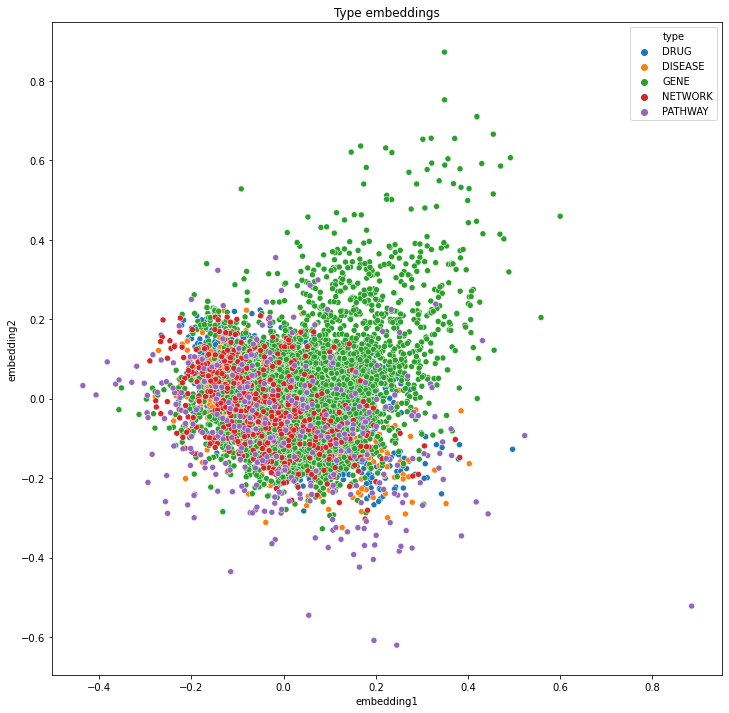

In [ ]:
plot_clusters("type",entityType_df)

# Clustering and plotting

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

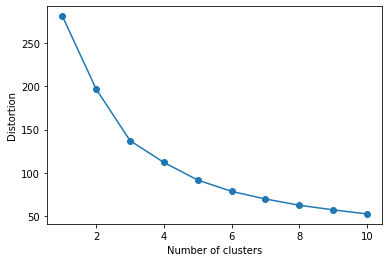

In [ ]:
# https://github.com/prakhargurawa/Machine-Learning-A-Z/blob/main/4_Clustering/k_means_clustering.py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d)
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# 3 is perfect for now

In [ ]:
clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
clusters = find_clusters(entities, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"entity": entities, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,entity,embedding1,embedding2,cluster
0,D00043,-0.076850,0.018087,cluster0
1,D00045,0.025234,-0.059357,cluster0
2,D00049,-0.027276,0.040983,cluster0
3,D00058,0.232849,0.028686,cluster2
4,D00059,0.041300,-0.011580,cluster0
...,...,...,...,...
16196,hsa05410,0.172123,-0.087180,cluster2
16197,hsa05412,0.141692,-0.130669,cluster2
16198,hsa05414,0.217255,-0.190099,cluster2
16199,hsa05416,-0.072542,-0.109388,cluster2


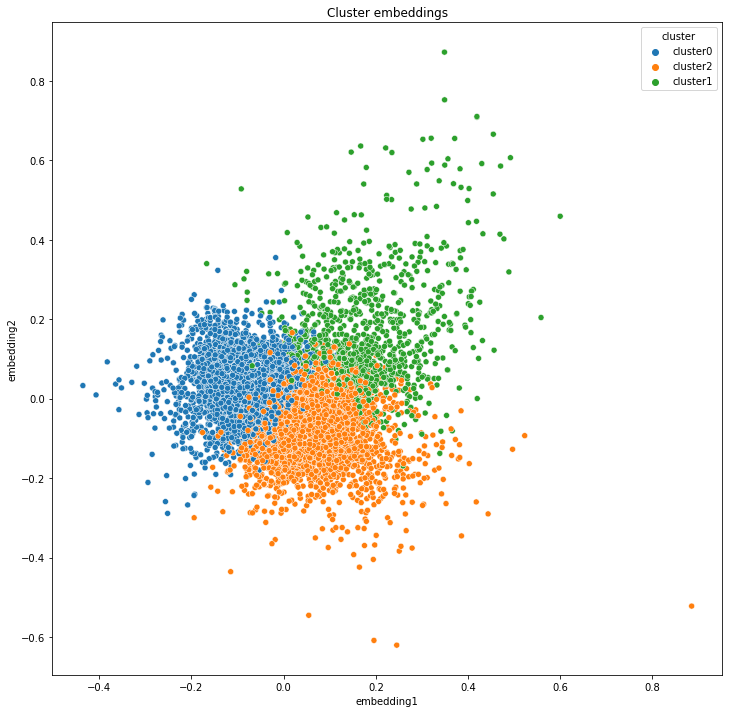

In [ ]:
plot_clusters("cluster",plot_df)

# Model Selection/ Hyperparameter settings

In [ ]:
import itertools
tf.logging.set_verbosity(tf.logging.ERROR)

ks = [100,200,300]                # dimension of embeddings         
optimizers = ['adam','sgd']       # adam optimizer and stochastic gradient optimizer
optimizers = ['adam']             # adam optimizer 
losss = ['bce']                   # Binary cross entropy loss, ConvE can work only with BCE loss  
lrs = [1e-3,1e-1]                 # Learning rate for optimizers 
lambdas = [1e-5,1e-2,1e-1]        # regularization constants
ps = [1,2,3]                      # L1,L2 or L3 (nuclear 3-norm) regularization

i = 0
for k,optimizer,loss,lr,lam,p in itertools.product(ks,optimizers,losss,lrs,lambdas,ps):
  print("\n################################################################################################################\n")
  try:
    print("Model configs ( Embedding size : ",k,", Optimizer : ",optimizer,", with learning rate : ",lr,", Loss : ",loss,",regularization type: ",p," regularization constant lambda: ",lam," )")
    model = ConvE(batches_count=100, 
                  seed=0, 
                  epochs=200, 
                  k=k, 
                  eta=5,
                  optimizer=optimizer, 
                  optimizer_params={'lr':lr},
                  loss=loss,                                 # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                  regularizer='LP', 
                  regularizer_params={'p':p, 'lambda':lam},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                  verbose=False)
    
    start_time = time.time()
    model.fit(data['train'], early_stopping = False)
    print("Execution time: %s seconds." % (time.time() - start_time))
    
    # modelname = './ConvE_model_'+str(i)+'.pkl'
    # print("Model saved as :",modelname)
    # save_model(model, modelname)
    print("Number : ",i)
    i=i+1

    ranks = evaluate_performance(data['test'],model=model,filter_triples=positives_filter,use_default_protocol=True,verbose=True)

    mrr = mrr_score(ranks)
    print("MRR: %.2f" % (mrr))
    hits_10 = hits_at_n_score(ranks, n=10)
    print("Hits@10: %.2f" % (hits_10))
    hits_3 = hits_at_n_score(ranks, n=3)
    print("Hits@3: %.2f" % (hits_3))
    hits_1 = hits_at_n_score(ranks, n=1)
    print("Hits@1: %.2f" % (hits_1))  
  except Exception as e:
    print("This configuration didn't worked out due to some technical error: ",e)
  print("\n################################################################################################################\n")


################################################################################################################

Model configs ( Embedding size :  100 , Optimizer :  adam , with learning rate :  0.001 , Loss :  bce ,regularization type:  1  regularization constant lambda:  1e-05  )
Execution time: 140.45343613624573 seconds.
Number :  0
Mapping set data: test
Mapping set data: filter
MRR: 0.22
Hits@10: 0.33
Hits@3: 0.23
Hits@1: 0.17

################################################################################################################


################################################################################################################

Model configs ( Embedding size :  100 , Optimizer :  adam , with learning rate :  0.001 , Loss :  bce ,regularization type:  2  regularization constant lambda:  1e-05  )
Execution time: 136.73868465423584 seconds.
Number :  1
Mapping set data: test
Mapping set data: filter
MRR: 0.22
Hits@10: 0.33
Hits@3: 0.23
Hits@1: 0.17

######

# Working with best model

After testing the model with different hyperparameters, we are going to us ethe best performing model from now.




In [ ]:
"""
Model configs ( Embedding size :  100 , Optimizer :  adam , with learning rate :  0.001 , Loss :  bce ,regularization type:  2  regularization constant lambda:  0.1  )
Execution time: 136.42216205596924 seconds.
Number :  7
Mapping set data: test
Mapping set data: filter
MRR: 0.28
Hits@10: 0.43
Hits@3: 0.30
Hits@1: 0.21
"""
model = ConvE(batches_count=50, 
                seed=0, 
                epochs=200, 
                k=100, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                embedding_model_params = {'dropout_dense':0.5,'dropout_conv':0.5},
                loss='bce',                     # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                regularizer='LP', 
                regularizer_params={'p':2,'lambda':1e-1},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                verbose=True)

# Possible loss functions: (Pairwise, max-margin loss),(Absolute margin, max-margin loss),(Self adversarial sampling loss),(Negative log-likelihood loss),(Multiclass NLL Loss),(Binary Cross Entropy Loss)
# Default initializer : Xaviers
# LUO18 : Timothee Lacroix, Nicolas Usunier, and Guillaume Obozinski. Canonical tensor decomposition for knowledge base completion. In International Conference on Machine Learning, 2869–2878. 2018.

In [ ]:
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
model.fit(data['train'], early_stopping = False)
print("Execution time: %s seconds." % (time.time() - start_time))

Average Loss:   5.277828: 100%|██████████| 200/200 [01:41<00:00,  1.97epoch/s]


Execution time: 107.89897441864014 seconds.


In [ ]:
from ampligraph.latent_features import save_model, restore_model
save_model(model, './ConvE_Best_Model')

In [ ]:
from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True,         # corrupt subj and obj separately while evaluating
                             verbose=True)

Mapping set data: test
Mapping set data: filter


100%|██████████| 18/18 [00:10<00:00,  1.67batch/s]


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.19
Hits@10: 0.31
Hits@3: 0.20
Hits@1: 0.14


In [ ]:
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

In [ ]:
len(entity_embeddings['D00043'])

100

In [ ]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [ ]:
ranks_unseen

array([   87,     1,     1,     1,     2,     1,     1,  6328, 10121,
          77,  6619,    38,  6016, 30561,   642,  1799, 27787,  7693,
       29769,   692,  4688], dtype=int32)

In [ ]:
scores = model.predict(X_unseen)

In [ ]:
scores # direct scores, hard to get insights from these

array([ 5.039001  ,  4.4494863 ,  3.902917  ,  4.5663843 ,  5.5831494 ,
        5.288099  ,  5.1072435 ,  0.49532193,  0.07632482,  3.138156  ,
        0.17432751,  4.260194  ,  0.19721964, -0.5013163 ,  1.982126  ,
        0.34322447, -0.24816695,  0.11354899, -0.80913126,  0.4447568 ,
        0.37785634], dtype=float32)

In [ ]:
from scipy.special import expit
probs = expit(scores)
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],
                      ranks_unseen,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
18,N00399 NETWORK_GENE N00399,29769,-0.809131,0.308076
13,D10845 DRUG_TARGET_PATHWAY hsa05230,30561,-0.501316,0.377231
16,H00242 DISEASE_GENE D11034,27787,-0.248167,0.438275
8,D11056 DRUG_TARGET_GENE HSA:7388,10121,0.076325,0.519072
17,D04905 DRUG_TARGET_PATHWAY N00399,7693,0.113549,0.528357
10,H00242 DISEASE_GENE HSA:6788,6619,0.174328,0.543472
12,N00399 NETWORK_GENE HSA:9217,6016,0.197220,0.549146
15,N00327 DISEASE_PATHWAY HSA:109,1799,0.343224,0.584974
20,N00060 DRUG_TARGET_PATHWAY hsa04380,4688,0.377856,0.593356
19,D10845 DRUG_TARGET_PATHWAY D07257,692,0.444757,0.609392


In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in entity_embeddings.values()]))
embeddings_2d[:2]

array([[ 0.00119422, -0.00924982],
       [-0.09063242,  0.03059788]], dtype=float32)

In [ ]:
entityTypeList = list(map(entityType,entities))
print(pd.DataFrame({"Entity": entities[:5],"Type":entityTypeList[:5]}))

   Entity  Type
0  D00043  DRUG
1  D00045  DRUG
2  D00049  DRUG
3  D00058  DRUG
4  D00059  DRUG


In [ ]:
entityType_df = pd.DataFrame({"entity": entities,
                "type":entityTypeList,
                "embedding1": embeddings_2d[:, 0], 
                "embedding2": embeddings_2d[:, 1],
                })
entityType_df

,entity,type,embedding1,embedding2
0,D00043,DRUG,0.001194,-0.009250
1,D00045,DRUG,-0.090632,0.030598
2,D00049,DRUG,-0.016789,-0.029123
3,D00058,DRUG,-0.076099,0.192074
4,D00059,DRUG,-0.045299,0.084287
...,...,...,...,...
16196,hsa05410,PATHWAY,-0.144977,-0.075994
16197,hsa05412,PATHWAY,-0.128432,-0.111576
16198,hsa05414,PATHWAY,-0.199714,-0.101537
16199,hsa05416,PATHWAY,0.031988,-0.120090


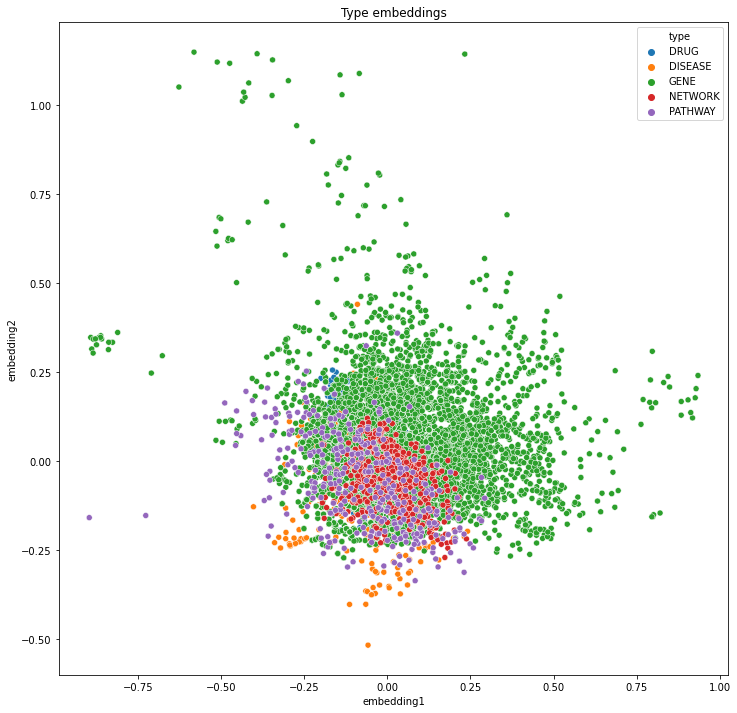

In [ ]:
def plot_clusters(hue,df,saved=False,figname='default.png'):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("{} embeddings".format(hue).capitalize())
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue)
  if saved==True:
    plt.savefig(figname,bbox_inches = 'tight')
plot_clusters("type",entityType_df,saved=True,figname="ConvE2DEntity.png")

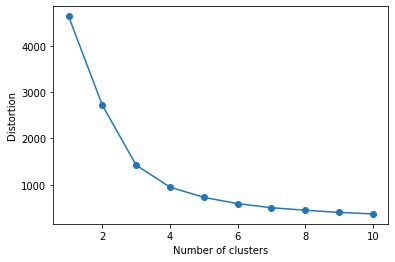

In [ ]:
# https://github.com/prakhargurawa/Machine-Learning-A-Z/blob/main/4_Clustering/k_means_clustering.py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d)
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# 4 is perfect for now

In [ ]:
clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
clusters = find_clusters(entities, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"entity": entities, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,entity,embedding1,embedding2,cluster
0,D00043,-0.051877,-0.024374,cluster0
1,D00045,0.038148,0.034499,cluster0
2,D00049,0.044550,-0.035981,cluster0
3,D00058,-0.018773,0.016446,cluster0
4,D00059,-0.027021,-0.019326,cluster0
...,...,...,...,...
16196,hsa05410,0.123084,0.222913,cluster1
16197,hsa05412,0.118231,0.177923,cluster1
16198,hsa05414,0.045232,0.190397,cluster1
16199,hsa05416,0.045006,0.007441,cluster1


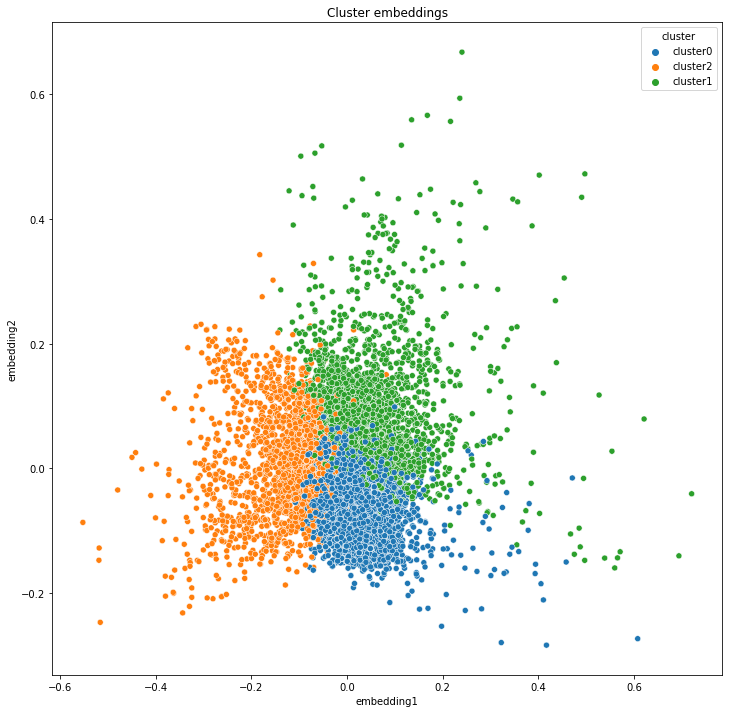

In [ ]:
plot_clusters("cluster",plot_df)